# Useful Imports

In [3]:
from KernelFlow import KernelFlowsCNNGP
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
import numpy as np
from utils import get_accuracy
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision.transforms as T
from torch import nn
import psutil
import time
from cnn_gp import Sequential, Conv2d, ReLU, resnet_block
from tqdm import tqdm
from scipy.linalg import lstsq
%load_ext autoreload
%autoreload 2

# Global parameters

In [4]:
N_I = 4

# Dataset

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                T.Lambda(lambda x: torch.flatten(x)),
                                T.Lambda(lambda x: nn.functional.normalize(x, p=2, dim=0)),
                                T.Lambda(lambda x: torch.reshape(x, (28,28))),
                                T.Lambda(lambda x: torch.unsqueeze(x, dim=0))
                              ])

batch_size = 10000
val_size = 500

# MNIST
trainset = datasets.MNIST('MNIST_dataset/train', download=True, train=True, transform=transform)
valset = datasets.MNIST('MNIST_dataset/val', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=val_size, shuffle=False)

# Fashion MNIST
# trainset = datasets.FashionMNIST('Fashion_MNIST_dataset/train', download=True, train=True, transform=transform)
# valset = datasets.FashionMNIST('Fashion_MNIST_dataset/val', download=True, train=False, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
# valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataiter = iter(trainloader)
X_train, Y_train = dataiter.next()
# X_train = nn.functional.normalize(X_train, p=2)
Y_train = F.one_hot(Y_train, 10)

dataiter_val = iter(valloader)
X_test, Y_test = dataiter_val.next()


# Model

In [6]:
model_untrained = Sequential(
        Conv2d(kernel_size=3),
        ReLU(),
        Conv2d(kernel_size=3, stride=2),
        ReLU(),
        Conv2d(kernel_size=14, padding=0),  # equivalent to a dense layer
        )

In [38]:
k_matrix = np.ones((X_train.shape), dtype=float)
k_matrix.shape

(10000, 1, 28, 28)

In [41]:
psutil.virtual_memory().percent


67.8

In [13]:
# Complete Kernel
k_full = model_untrained(X_train[0:120], X_train[0:125])
psutil.virtual_memory().percent


69.2

In [40]:
# Blockwise Kernel
k_blocked = KernelFlowsCNNGP._block_kernel_eval(X=X_train[0:200],
                                                        Y=X_train[0:200].to(torch.float32),
                                                        blocksize=100,
                                                        kernel=model_untrained)

100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


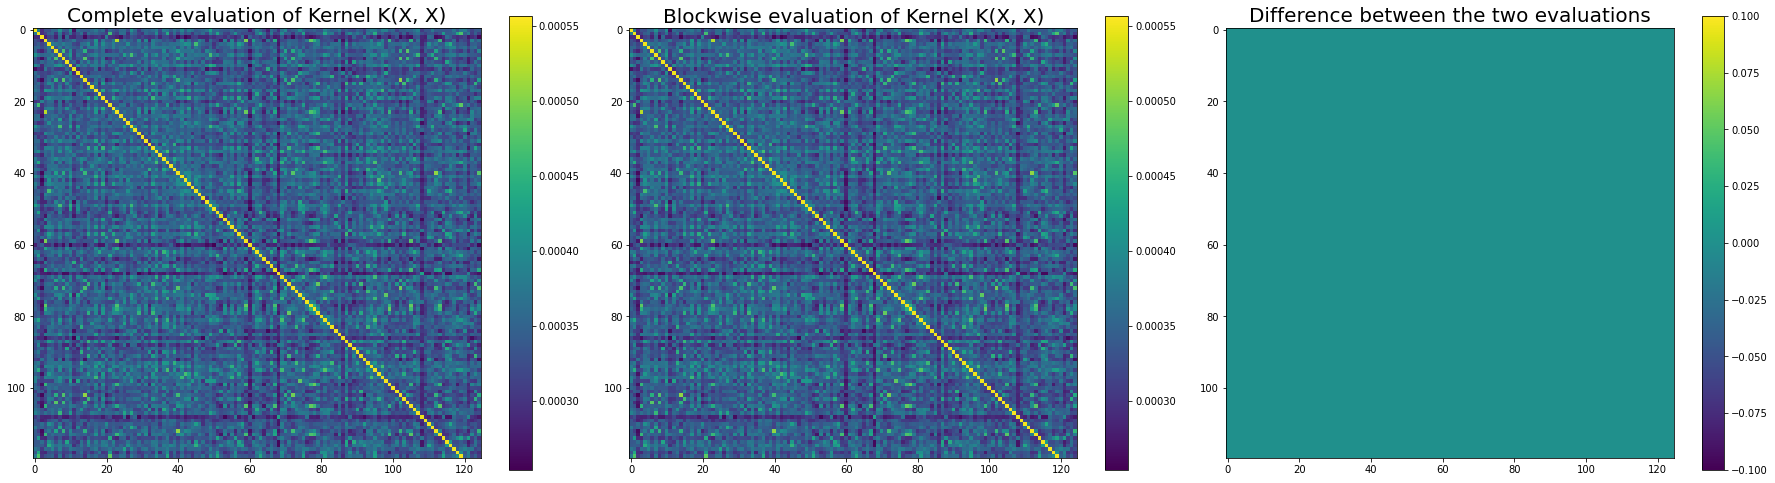

In [25]:
fig, ax = plt.subplots(1,3, figsize=(25,10))
pos0 = ax[0].imshow(k_full[:120,:125].detach().numpy())
ax[0].set_title('Complete evaluation of Kernel K(X, X)', fontsize=20)
pos1= ax[1].imshow(k_blocked[:120,:125].detach().numpy())
ax[1].set_title('Blockwise evaluation of Kernel K(X, X)', fontsize=20)
pos2 = ax[2].imshow(k_blocked[:120,:125].detach().numpy() - k_full[:120,:125].detach().numpy())
ax[2].set_title('Difference between the two evaluations', fontsize=20)
plt.tight_layout()
fig.colorbar(pos0, ax=ax[0], location='right', shrink=0.65)
fig.colorbar(pos1, ax=ax[1], location='right', shrink=0.65)
fig.colorbar(pos2, ax=ax[2], location='right', shrink=0.65)
# fig.savefig('figs/illconditioned_blockwise_kernel_evals.png')

# Pretraining Results

In [28]:
Y_pred_untrained = KernelFlowsCNNGP.kernel_regression(X_test=X_test, X_train = X_train[:125], Y_train = Y_train[:125].to(torch.float32), kernel = model_untrained, blocksize=False)
Y_pred_untrained = torch.argmax(Y_pred_untrained, axis=1)
accuracy_untrained = get_accuracy(Y_pred_untrained.detach().numpy(), Y_test.detach().numpy())
print("The accuracy with training was: ", accuracy_untrained)

Condition numbers of k_matrix and t_matrix are:  tensor(347.1073, grad_fn=<SqueezeBackward1>) tensor(14601.5059, grad_fn=<SqueezeBackward1>)
The accuracy with training was:  77.0


In [6]:
Y_pred_untrained_blocked = KernelFlowsCNNGP.kernel_regression(X_test=X_test, X_train = X_train[:500], Y_train = Y_train[:500].to(torch.float32), kernel = model_untrained, blocksize=100)
Y_pred_untrained_blocked = torch.argmax(Y_pred_untrained_blocked, axis=1)
accuracy_untrained_blocked = get_accuracy(Y_pred_untrained_blocked.detach().numpy(), Y_test.detach().numpy())
print("The accuracy with training was: ", accuracy_untrained_blocked)

 20%|██        | 1/5 [00:03<00:14,  3.60s/it]

In [ ]:
N_i_arr = np.arange(50, 400, 50)
untrained_accuracy_list = []

for ni in tqdm(N_i_arr):
    Y_pred_untrained = KernelFlowsCNNGP.kernel_regression(X_test=X_test, X_train = X_train[:ni], Y_train = Y_train[:ni].to(torch.float32), kernel = model_untrained)
    Y_pred_untrained = torch.argmax(Y_pred_untrained, axis=1)
    untrained_accuracy_list.append(get_accuracy(Y_pred_untrained.detach().numpy(), Y_test.detach().numpy()))

: 

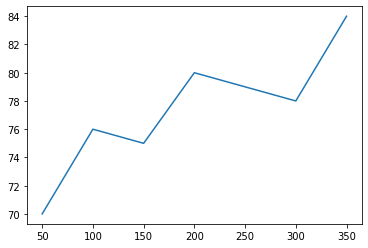

In [10]:
plt.plot(N_i_arr, untrained_accuracy_list)

# Training the model

In [11]:
model_trained = Sequential(
        Conv2d(kernel_size=3),
        ReLU(),
        Conv2d(kernel_size=3, stride=2),
        ReLU(),
        Conv2d(kernel_size=14, padding=0),  # equivalent to a dense layer
        )



In [12]:
model_trained.load_state_dict(torch.load('models/simple_1000_iter.pth'))

<All keys matched successfully>

In [14]:
N_i_arr = np.arange(50, 400, 50)
trained_accuracy_list = []

for ni in tqdm(N_i_arr):
    Y_pred_trained = KernelFlowsCNNGP.kernel_regression(X_test=X_test, X_train = X_train[:ni], Y_train = Y_train[:ni].to(torch.float32), kernel = model_trained)
    Y_pred_trained = torch.argmax(Y_pred_trained, axis=1)
    trained_accuracy_list.append(get_accuracy(Y_pred_trained.detach().numpy(), Y_test.detach().numpy()))

100%|██████████| 7/7 [00:52<00:00,  7.53s/it]


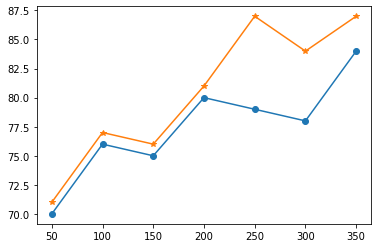

In [15]:
plt.plot(N_i_arr, untrained_accuracy_list, '-o')
plt.plot(N_i_arr, trained_accuracy_list, '-*')